# Result Reproducibility (CSIQ database evaluation)
You can reproduce our paper results following this notebook.

Please, first download the dataset and unzip it within this notebook folder.

The CSIQ dataset can be downloaded from [this link](https://s2.smu.edu/~eclarson/csiq.html)

also to run this code, libraries should be installed from `pip install -r requirements.txt`

### 1- Importing necessary libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

from similarity_metrics.fsim_quality import FSIMsimilarity
from similarity_metrics.issm_quality import ISSMsimilarity
from CopulaSimilarity.CSM import CopulaBasedSimilarity as CSIMSimilarity
from similarity_metrics.ssim_rmse_psnr_metrics import ssim

### 2- Defining all similarity metrics and image loader

In [3]:
class SimilarityMetrics:
    def __init__(self):
        self.fsim_similarity = FSIMsimilarity()
        self.issm_similarity = ISSMsimilarity()
        self.copula_similarity = CSIMSimilarity()

    def compute_ssim(self, image_1, image_2):
        return ssim(image_1, image_2)

    def compute_fsim(self, image_1, image_2):
        return self.fsim_similarity.fsim(image_1, image_2)

    def compute_issm(self, image_1, image_2):
        return self.issm_similarity.issm(image_1, image_2)

    def compute_csim(self, image_1, image_2):
        csim = self.copula_similarity.compute_local_similarity(image_1, image_2)
        return np.mean(csim)

def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### 3- Loading CSIQ dataset

Depending on you hardward, this steps might take time to get complete. If you want to visualize the result without looping over the dataset, you can skip to next code cell.

In [1]:
import os

original_dir = 'dataset/original'
distorted_dir = 'dataset/distorted'

# Count the total number of original images
original_images = os.listdir(original_dir)
total_original_images = len(original_images)
print(f"Total original images: {total_original_images}")

# Count the total number of distorted images
total_distorted_images = 0
for folder in os.listdir(distorted_dir):
    distorted_folder_path = os.path.join(distorted_dir, folder)
    distorted_images = os.listdir(distorted_folder_path)
    total_distorted_images += len(distorted_images)
print(f"Total distorted images: {total_distorted_images}")

# Count the number of distorted images per original image
distorted_images_per_original = {}
for folder in os.listdir(distorted_dir):
    distorted_folder_path = os.path.join(distorted_dir, folder)
    for file in os.listdir(distorted_folder_path):
        original_image_name = file.split('.')[0]
        if original_image_name not in distorted_images_per_original:
            distorted_images_per_original[original_image_name] = 0
        distorted_images_per_original[original_image_name] += 1

print("Distorted images per original image:")
for original_image, count in distorted_images_per_original.items():
    print(f"{original_image}: {count}")

Total original images: 30
Total distorted images: 900
Distorted images per original image:
veggies: 30
lake: 30
swarm: 30
couple: 30
log_seaside: 30
bridge: 30
child_swimming: 30
redwood: 30
snow_leaves: 30
1600: 30
woman: 30
monument: 30
cactus: 30
rushmore: 30
geckos: 30
roping: 30
sunset_sparrow: 30
lady_liberty: 30
shroom: 30
sunsetcolor: 30
native_american: 30
foxy: 30
boston: 30
family: 30
elk: 30
turtle: 30
trolley: 30
fisher: 30
aerial_city: 30
butter_flower: 30


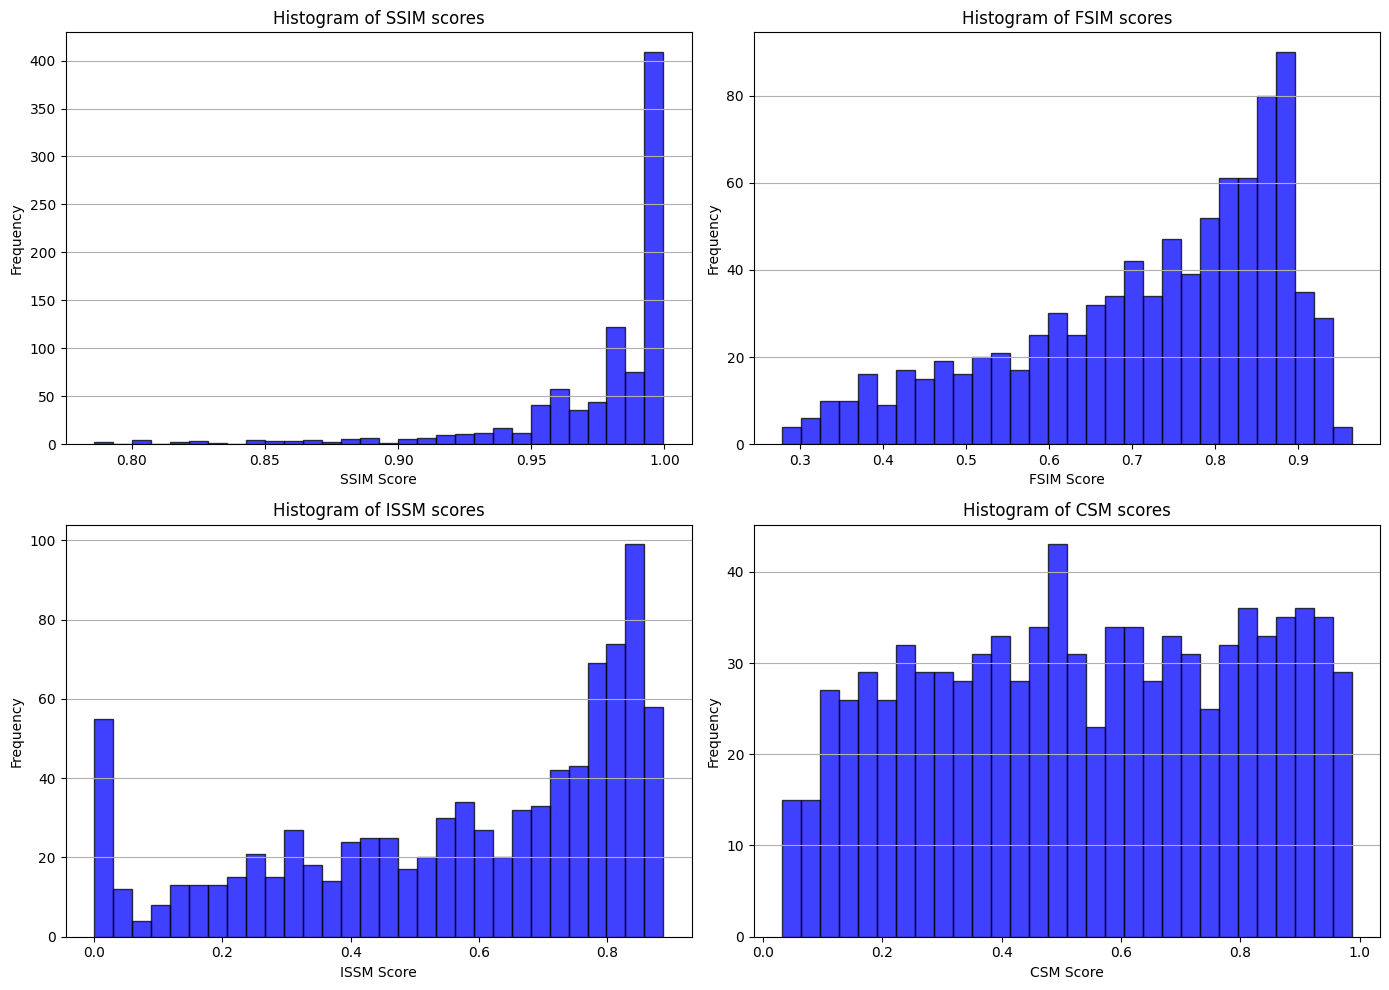

In [44]:
original_dir = 'dataset/original'
distorted_dir = 'dataset/distorted'

metrics = SimilarityMetrics()
similarity_scores = {'SSIM': [], 'FSIM': [], 'ISSM': [], 'CSIM': [], 'distortion_type': []}

for original_image_name in os.listdir(original_dir):
    original_image_path = os.path.join(original_dir, original_image_name)
    original_image = load_image(original_image_path)
    
    if original_image is None:
        continue
    
    for distortion_type in os.listdir(distorted_dir):
        distortion_path = os.path.join(distorted_dir, distortion_type)
        
        for distorted_image_name in os.listdir(distortion_path):
            if distorted_image_name.startswith(original_image_name.split('.')[0]):
                distorted_image_path = os.path.join(distortion_path, distorted_image_name)
                distorted_image = load_image(distorted_image_path)
                
                if distorted_image is None:
                    continue
                
                ssim_value = metrics.compute_ssim(original_image, distorted_image)
                fsim_value = metrics.compute_fsim(original_image, distorted_image)
                issm_value = metrics.compute_issm(original_image, distorted_image)
                csim_value = metrics.compute_csim(original_image, distorted_image)
                
                similarity_scores['SSIM'].append(ssim_value)
                similarity_scores['FSIM'].append(fsim_value)
                similarity_scores['ISSM'].append(issm_value)
                similarity_scores['CSIM'].append(csim_value)
                similarity_scores['distortion_type'].append(distortion_type)

plt.figure(figsize=(14, 10))
for i, (metric_name, scores) in enumerate(similarity_scores.items(), 1):
    if metric_name != 'distortion_type':
        plt.subplot(2, 2, i)
        plt.hist(scores, bins=30, alpha=0.75, color='b', edgecolor='black')
        plt.title(f'Histogram of {metric_name} scores')
        plt.xlabel(f'{metric_name} Score')
        plt.ylabel('Frequency')
        plt.grid(axis='y')

plt.tight_layout()
plt.show()

with open('pkldata/similarity_scores_.pkl', 'wb') as f:
    pickle.dump(similarity_scores, f)


### 4- Visualize the results

You can run the following code cells without the need of previous cells. Make sure the path of the `similarity_scores.pkl` is correct (default `'pkldata/similarity_scores.pkl'`)

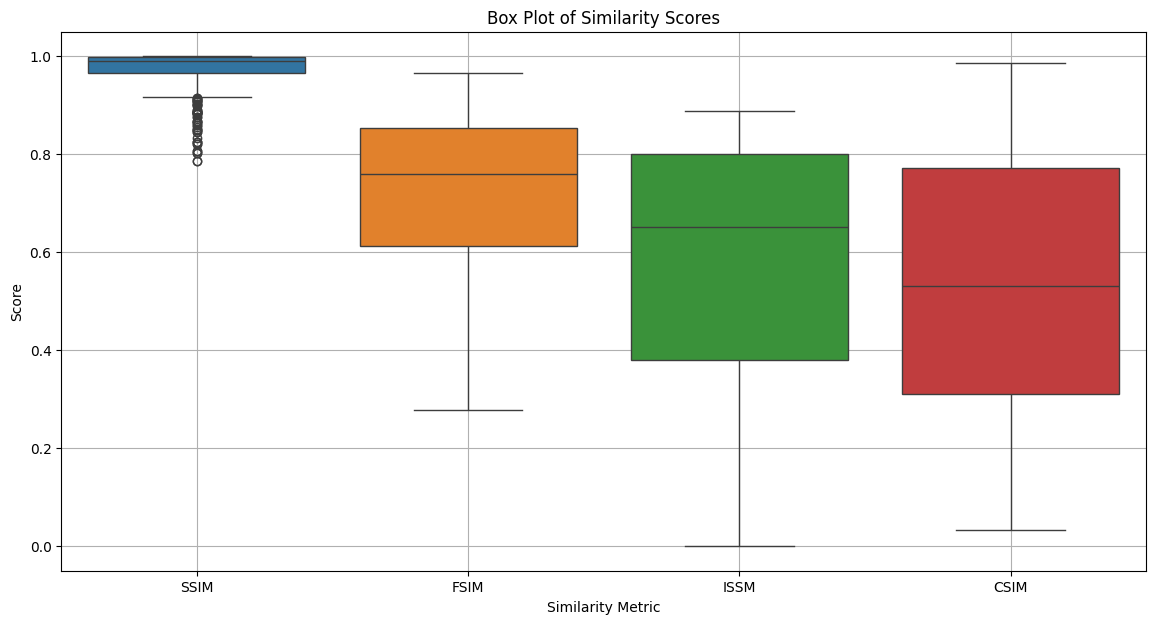

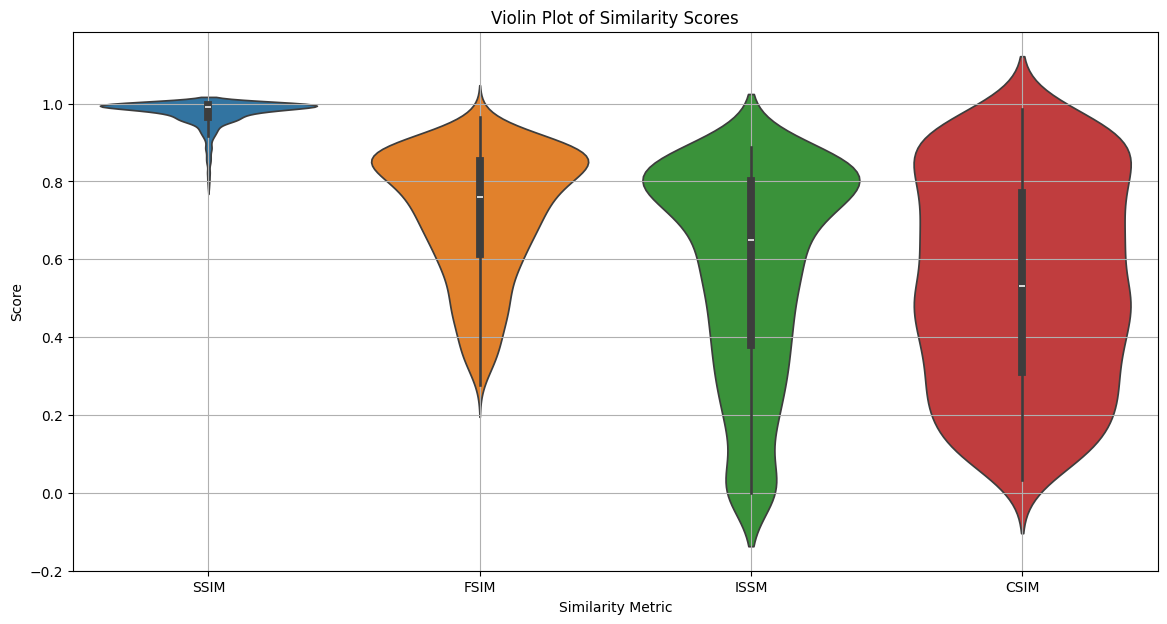

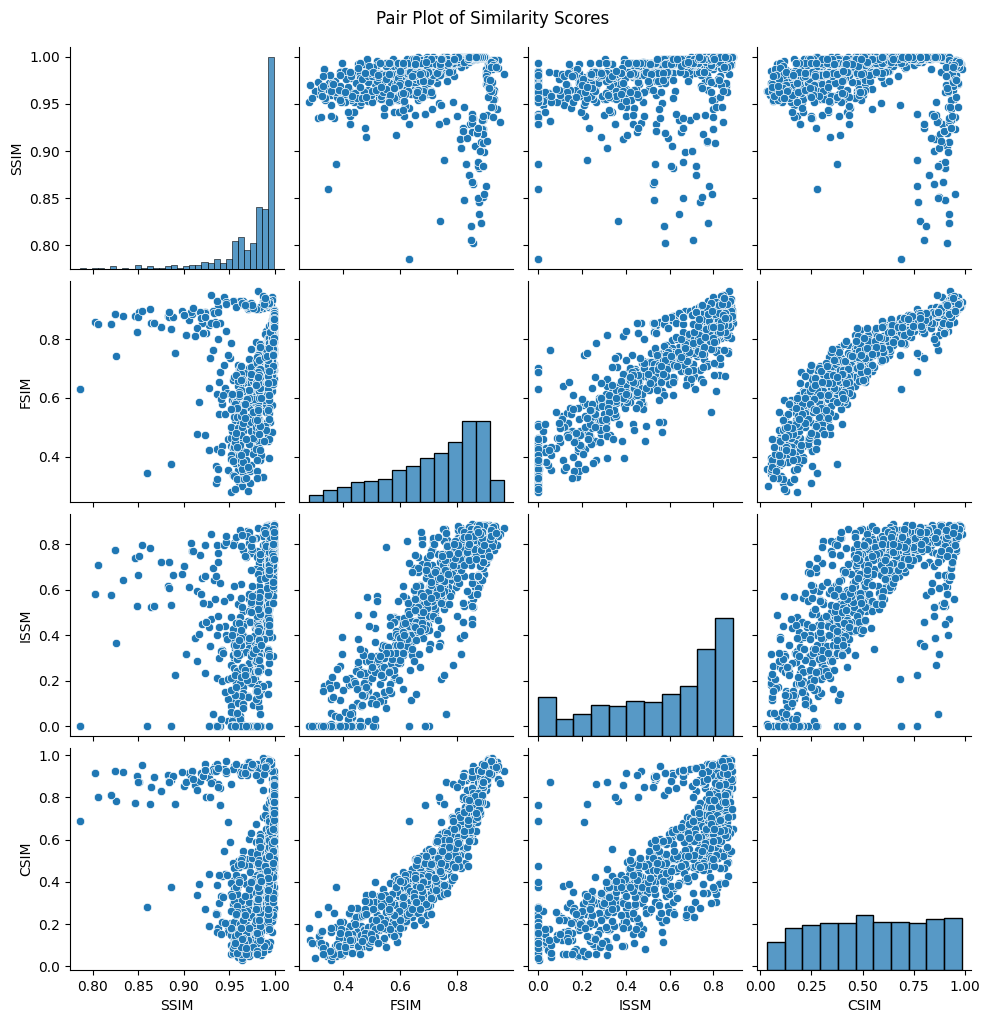

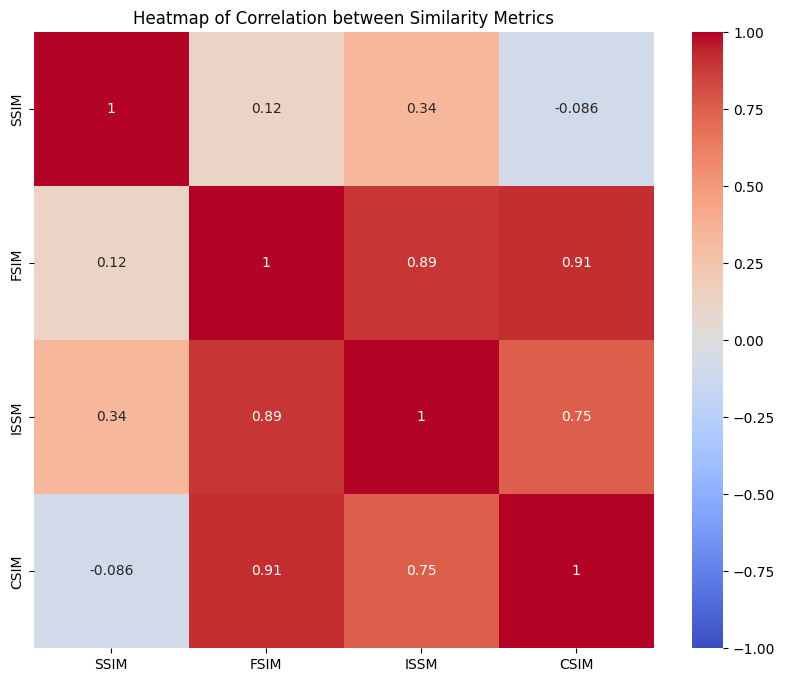

In [20]:
import pandas as pd
import seaborn as sns

with open('pkldata/similarity_scores.pkl', 'rb') as f:
    similarity_scores = pickle.load(f)

if 'CSM' in similarity_scores:
    similarity_scores['CSIM'] = similarity_scores.pop('CSM')
    
df = pd.DataFrame(similarity_scores)

plt.figure(figsize=(14, 7))
sns.boxplot(data=df)
plt.title('Box Plot of Similarity Scores')
plt.xlabel('Similarity Metric')
plt.ylabel('Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
sns.violinplot(data=df)
plt.title('Violin Plot of Similarity Scores')
plt.xlabel('Similarity Metric')
plt.ylabel('Score')
plt.grid(True)
plt.show()

sns.pairplot(df)
plt.suptitle('Pair Plot of Similarity Scores', y=1.02)
plt.show()

df_numerical = df.drop(columns=['distortion_type'])

plt.figure(figsize=(10, 8))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between Similarity Metrics')
plt.show()


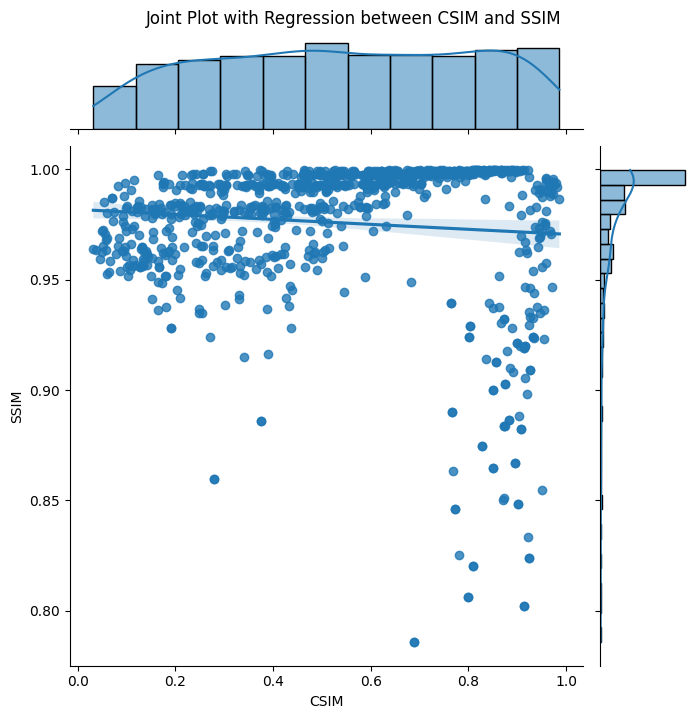

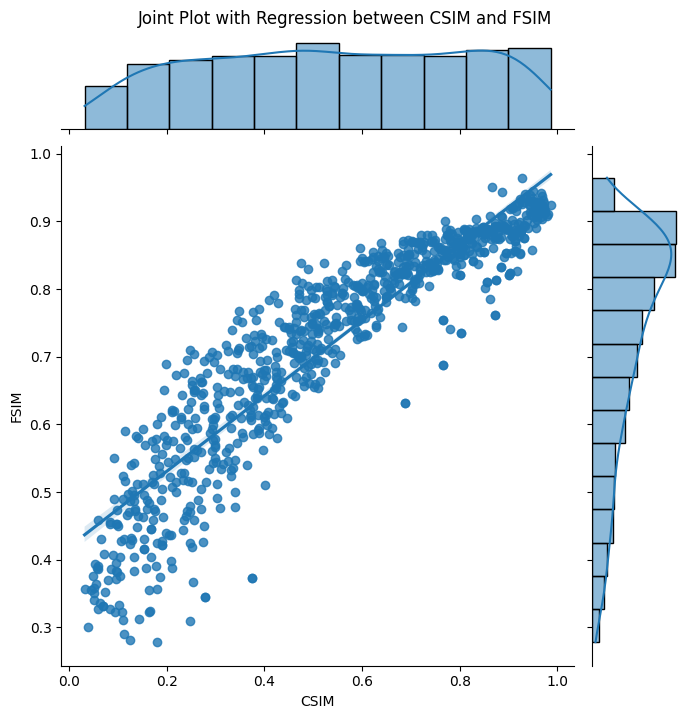

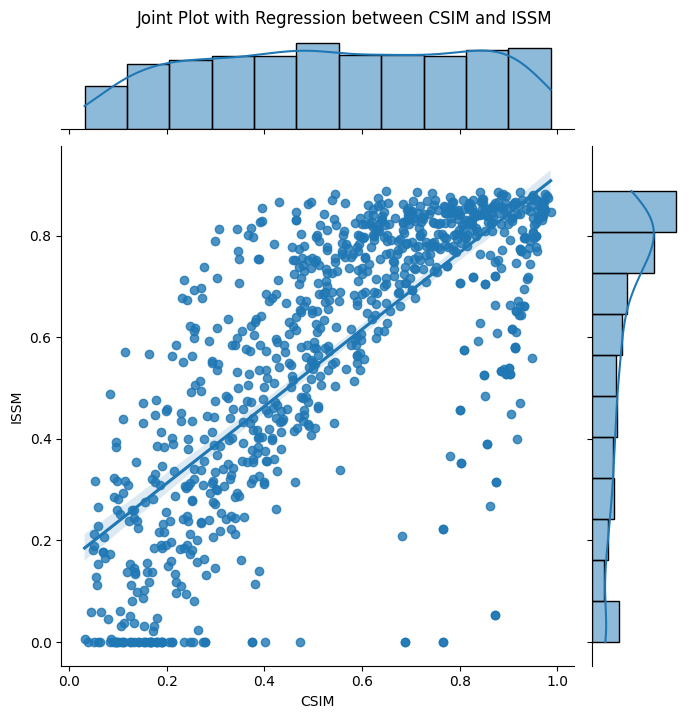

In [22]:
for col in df_numerical.columns:
    if col != 'CSIM':
        sns.jointplot(data=df_numerical, x='CSIM', y=col, kind='reg', height=7, ratio=5)
        plt.suptitle(f'Joint Plot with Regression between CSIM and {col}', y=1.02)
        plt.show()

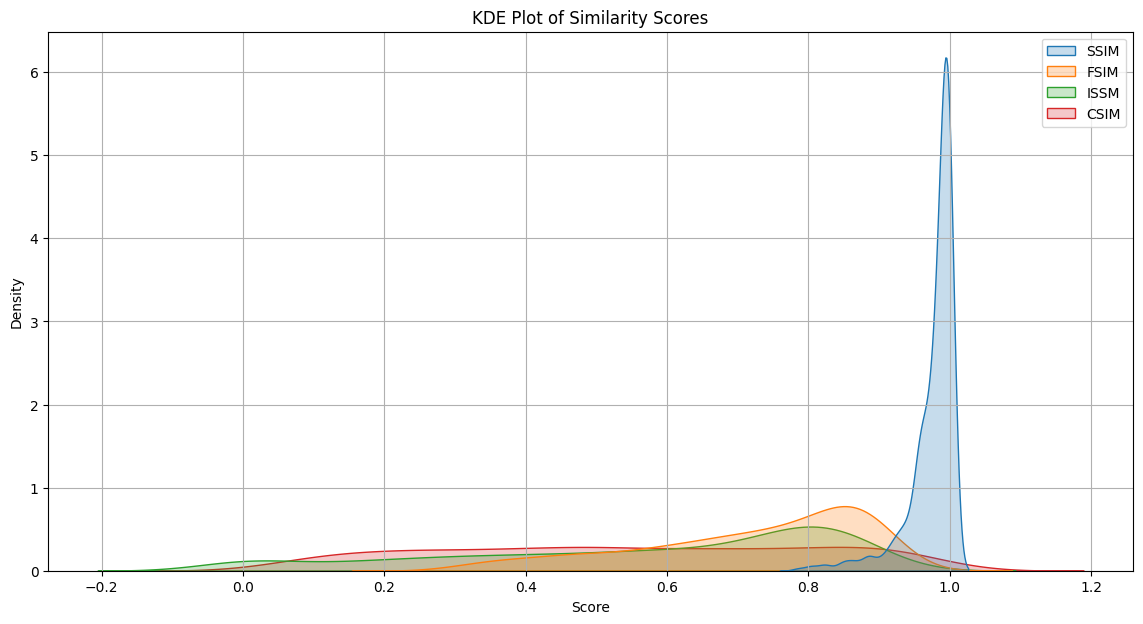

In [23]:
# KDE Plot
plt.figure(figsize=(14, 7))
sns.kdeplot(data=df, fill=True)
plt.title('KDE Plot of Similarity Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()


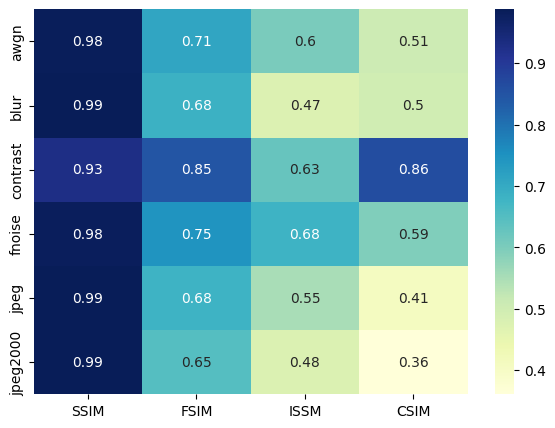

In [24]:
average_scores = df.groupby('distortion_type').mean()
plt.figure(figsize=(7, 5))
sns.heatmap(average_scores, annot=True, cmap='YlGnBu')
plt.ylabel('')
plt.savefig('heatmap_average_scores.pdf', format='pdf')
plt.show()

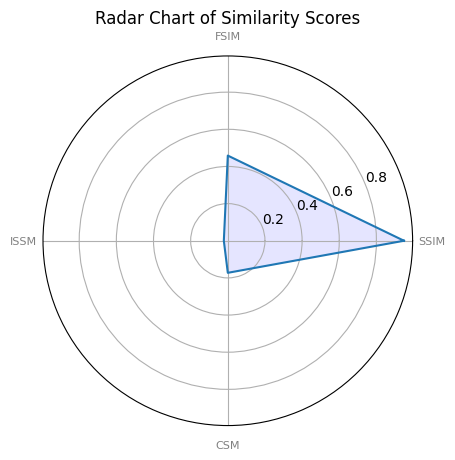

In [34]:
from math import pi

categories = list(df.columns)
N = len(categories)

values = df.loc[0].values.flatten().tolist() 
values += values[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.plot(angles, values)
ax.fill(angles, values, 'b', alpha=0.1)
plt.title('Radar Chart of Similarity Scores')
plt.show()


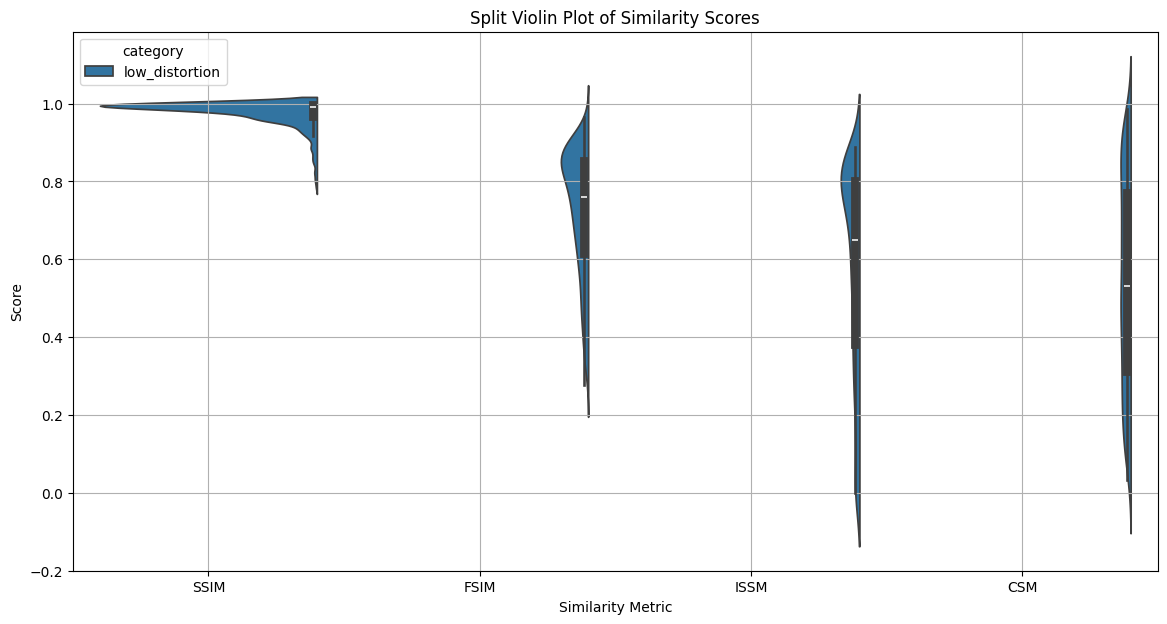

In [39]:
df['category'] = df['SSIM'].apply(lambda x: 'high_distortion' if x < 0.5 else 'low_distortion')

plt.figure(figsize=(14, 7))
sns.violinplot(x='variable', y='value', hue='category', data=pd.melt(df, id_vars='category'), split=True)
plt.title('Split Violin Plot of Similarity Scores')
plt.xlabel('Similarity Metric')
plt.ylabel('Score')
plt.grid(True)
plt.show()


<Figure size 7000x5000 with 0 Axes>

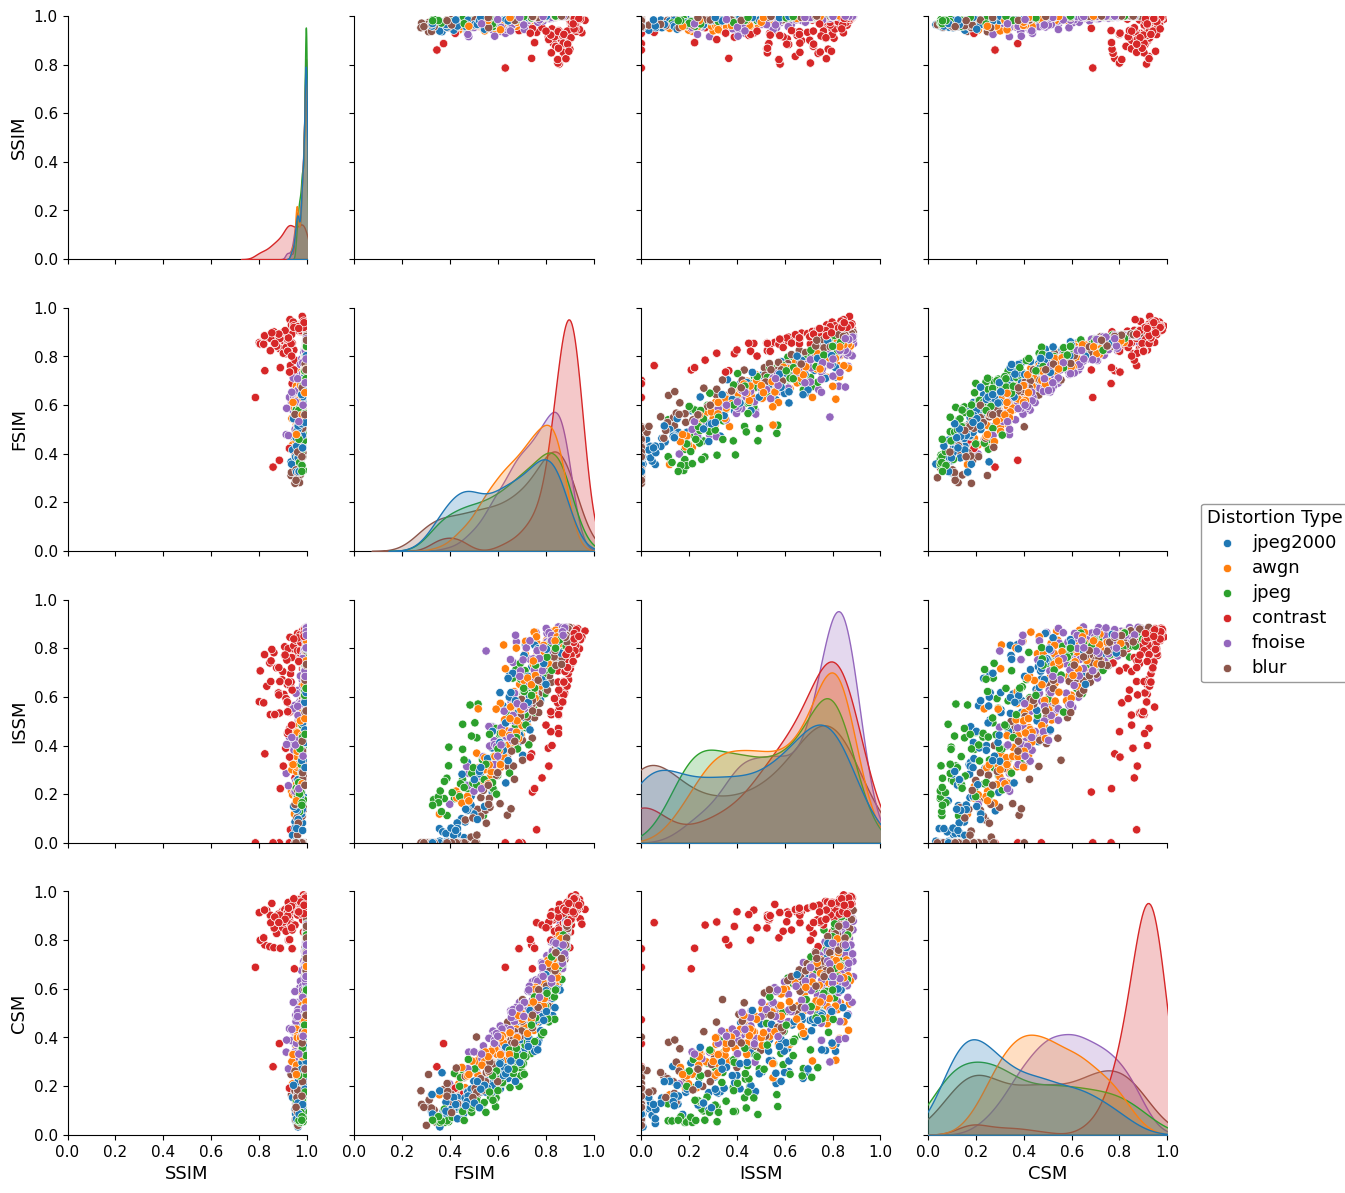

In [23]:
plt.figure(figsize=(70, 50))  
g = sns.pairplot(df, hue='distortion_type', height=3)

for ax in g.axes.flat:
    ax.set_ylim(0, 1) 
    ax.set_xlim(0, 1)
    ax.tick_params(axis='both', labelsize=11)
    ax.set_xlabel(ax.get_xlabel(), fontsize=13) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=13)  

g._legend.set_title('Distortion Type', prop={'size': 13})
for label in g._legend.get_texts():
    label.set_fontsize(13)

g._legend.set_bbox_to_anchor((1.03, 0.5)) 
g._legend.set_frame_on(True)
g._legend.get_frame().set_facecolor('none') 
g._legend.get_frame().set_edgecolor('grey')  

plt.subplots_adjust(wspace=0.2, hspace=0.20)

plt.savefig('similarity_scores_by_distortion_type.pdf', format='pdf', bbox_inches='tight')

plt.show()

/tmp/ipykernel_3547188/751821794.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


<Figure size 7000x5000 with 0 Axes>

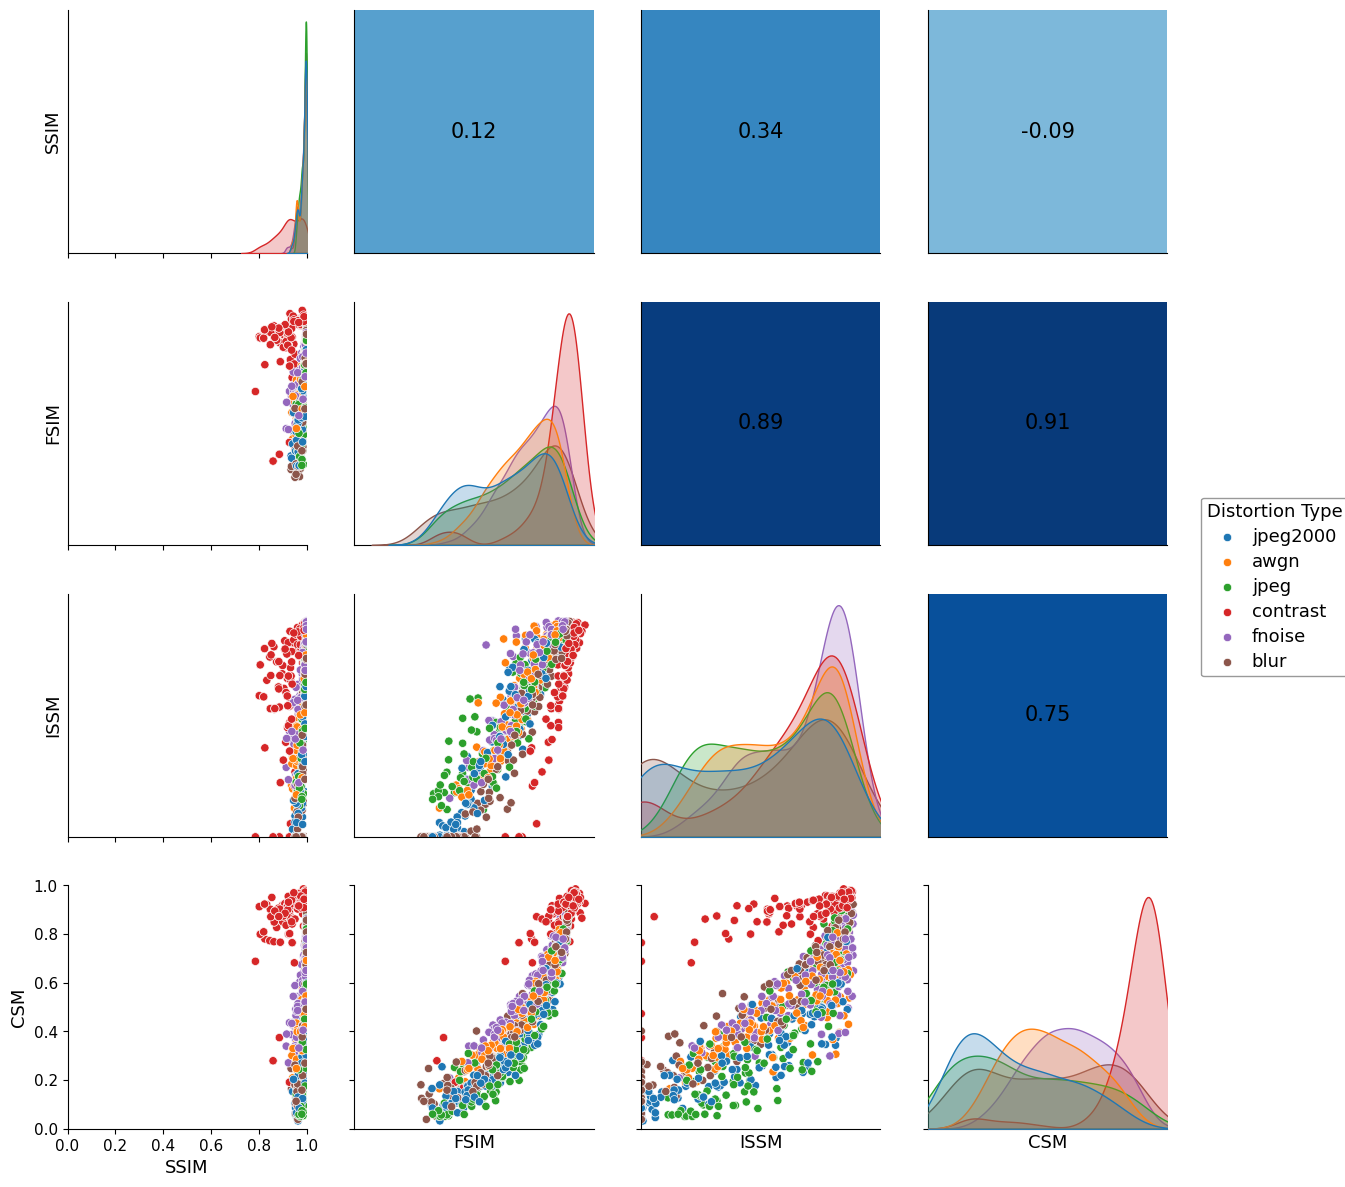

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Create the pairplot
plt.figure(figsize=(70, 50))  
g = sns.pairplot(df, hue='distortion_type', height=3)

# Create a colormap for the correlation values (blue shades)
cmap = cm.get_cmap('Blues')
norm = Normalize(vmin=-1, vmax=1)

# Replace upper triangle scatter plots with color-filled boxes and correlation coefficients
for i, j in zip(*np.triu_indices_from(g.axes, 1)):  # 1 for upper triangle
    # Clear the scatter plot
    g.axes[i, j].cla()  # Clear the axis
    
    # Calculate correlation
    corr = df[df.columns[i]].corr(df[df.columns[j]])
    
    # Fill the background with a color corresponding to the correlation value
    g.axes[i, j].set_facecolor(cmap(norm(corr)))
    
    # Annotate with correlation value
    g.axes[i, j].annotate(f'{corr:.2f}', xy=(0.5, 0.5), 
                          xycoords='axes fraction', 
                          ha='center', va='center', fontsize=15, color='black')

    # Remove axis ticks and labels
    g.axes[i, j].set_xticks([])
    g.axes[i, j].set_yticks([])
    g.axes[i, j].set_xlabel('')
    g.axes[i, j].set_ylabel('')

# Set limits, labels, and font sizes for scatter plots in the lower triangle
for ax in g.axes.flat:
    ax.set_ylim(0, 1) 
    ax.set_xlim(0, 1)
    ax.tick_params(axis='both', labelsize=11)
    ax.set_xlabel(ax.get_xlabel(), fontsize=13) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=13)  

# Adjust legend styling
g._legend.set_title('Distortion Type', prop={'size': 13})
for label in g._legend.get_texts():
    label.set_fontsize(13)

g._legend.set_bbox_to_anchor((1.03, 0.5)) 
g._legend.set_frame_on(True)
g._legend.get_frame().set_facecolor('none') 
g._legend.get_frame().set_edgecolor('grey')  

# Adjust subplot layout
plt.subplots_adjust(wspace=0.2, hspace=0.20)

# Save and show the plot
plt.savefig('similarity_scores_by_distortion_type.pdf', format='pdf', bbox_inches='tight')
plt.show()
